In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy 
from IPython.display import clear_output
import seaborn as sns
import scipy.stats
import chaospy
from CADETProcess.processModel import ComponentSystem
from CADETProcess.processModel import Inlet, GeneralRateModel, Outlet
from CADETProcess.processModel import FlowSheet
from CADETProcess.processModel import Process
from CADETProcess.processModel import Langmuir
from CADETProcess.simulator import Cadet
from CADETProcess.solution import SolutionIO
from CADETProcess.comparison import Comparator
from CADETProcess.optimization import OptimizationProblem
from CADETProcess.optimization import TrustConstr
from CADETProcess.optimization import U_NSGA3
from CADETProcess.optimization import SLSQP


from CADETProcess.reference import ReferenceIO
import seaborn as sns
sns.set_theme()

In [2]:
def add_noise(reference,mu,sigma) :
    rng = np.random.default_rng()
    noise = rng.standard_normal(reference.shape)*sigma +mu
    return reference + noise

def compute_parameters(reference,process) : 
    comparator = Comparator()
    comparator.add_reference(reference)
    comparator.add_difference_metric('RMSE', reference, 'column.outlet')
    
    optimization_problem = OptimizationProblem('adsorption_rate_capacity')
    
    optimization_problem.add_evaluation_object(process)
    optimization_problem.add_variable(
    name='adsorption_rate', parameter_path='flow_sheet.column.binding_model.adsorption_rate')
    
    optimization_problem.add_variable(
        name='capacity', parameter_path='flow_sheet.column.binding_model.capacity')
    
    simulator = Cadet()
    optimization_problem.add_evaluator(simulator)

    optimization_problem.add_objective(
    comparator,
    n_objectives=comparator.n_metrics,
    requires=[simulator]
    )

    optimizer = TrustConstr()
    
    optimizer.gtol = 1e-5
    optimizer.xtol = 1e-5
    optimizer.maxiter= 50
    optimizer.verbose = 0
    initial_tr_radius=0.3
    optimizer.disp = False
    
     
    
    """
    optimizer = U_NSGA3()
    optimizer.n_cores = 8
    optimizer.pop_size = 32
    optimizer.n_max_gen = 8
    """
    """
    optimizer = SLSQP()
    
    optimizer.ftol = 1e-5
    optimizer.max_iter = 50
    optimizer.disp = True
    optimizer.iprint = 1 """
    
    optimization_results = optimizer.optimize(
    optimization_problem,
    x0 = [5.7,4.88],
    
    use_checkpoint=False
    )

    return (np.array(optimization_results.x)).flatten()

def forward_run(process):
        
    simulator = Cadet()
    simulation_results = simulator.simulate(process)
    
    sol = simulation_results.solution.outlet.outlet.solution.flatten()
    
    
    return sol[:1501]

def configure_process(T_inj, m) :
    component_system = ComponentSystem(1) 

    inlet = Inlet(component_system,"inlet")

    inlet.c = 0
    inlet.flow_rate = 1.67e-8

    binding_model = Langmuir(component_system)
    binding_model.is_kinetic = False
    binding_model.adsorption_rate = 5.7
    binding_model.desorption_rate = 1
    binding_model.capacity = 4.88

    column = GeneralRateModel(component_system, "column")
    column.binding_model = binding_model 

    column.length = 0.014 #m
    column.particle_radius = 4.5e-5
    column.bed_porosity = 0.37 
    column.particle_porosity = 0.75
    column.film_diffusion = 6.9e-6
    column.axial_dispersion = 5.75e-8
    column.pore_diffusion = 6.07e-11
    column.surface_diffusion = 0

    column.set_diameter_from_interstitial_velocity(Q=1.67e-8,u0=5.75e-4)

    outlet = Outlet(component_system, "outlet")

    flow_sheet = FlowSheet(component_system) 
    flow_sheet.add_unit(inlet)
    flow_sheet.add_unit(column)
    flow_sheet.add_unit(outlet)

    flow_sheet.add_connection(inlet, column)
    flow_sheet.add_connection(column, outlet)

    process = Process(flow_sheet, 'process')
    process.cycle_time = 1500  # s

    V = 1.67e-8 #Volumetric Flow Rate in m^3/s 
    
    c_inj = (1e-6)*m/(V*14.7*T_inj) #now correctly in mol / m^3
    event = process.add_event ("inject on", 'flow_sheet.inlet.c',c_inj ,0)
    process.add_event('inject off', 'flow_sheet.inlet.c', 0, T_inj)
    
    return process

def resampling(parameter_estimates) :
    p_runs = len(parameter_estimates)
    d_opt_criterion = lambda x,y: np.linalg.det(np.cov(np.array([x,y])))
    confidence_intervals = np.zeros((len(parameter_estimates),2))
    for i in range(p_runs):

        bootstrap_result = scipy.stats.bootstrap(parameter_estimates[i,:].T,d_opt_criterion,paired=True,n_resamples = 999)
        confidence_intervals[i,0] =bootstrap_result.confidence_interval.low
        confidence_intervals[i,1] = bootstrap_result.confidence_interval.high
        
    return confidence_intervals

In [3]:
duration =1501 # [s] 
runs = 18
samples = 1000
m_nom = 1 # [mg] (!!!!) Order of Magnitude Error in the Paper 
M_Lysin = 14.3 #[kg / mol] (!!!!) Order of Magnitude-Error in the Paper 
T_nom = [60 +j*47 for j in range(runs)] # [s]
print(T_nom)

[60, 107, 154, 201, 248, 295, 342, 389, 436, 483, 530, 577, 624, 671, 718, 765, 812, 859]


In [ ]:
'''
Create Artificial Measurement Data by adding gaussian noise to chromatograms 
If you run this cell, this will rödel for some time
'''

sigma_meas = 9e-4

for i in range(runs) : 
    std_artificial_data = np.zeros((samples,duration))
    process = configure_process(T_nom[i],m_nom)      
    numerical_solution = forward_run(process).flatten()
    for j in range(samples):
        std_artificial_data[j,:] = add_noise(numerical_solution,0,sigma_meas)
    np.savetxt("data/samples/std_sample_"+str(i)+".csv", std_artificial_data ,delimiter = ",", header = '') 
    if i % 10 == 0:
        print("iteration: " + str(i))     
    

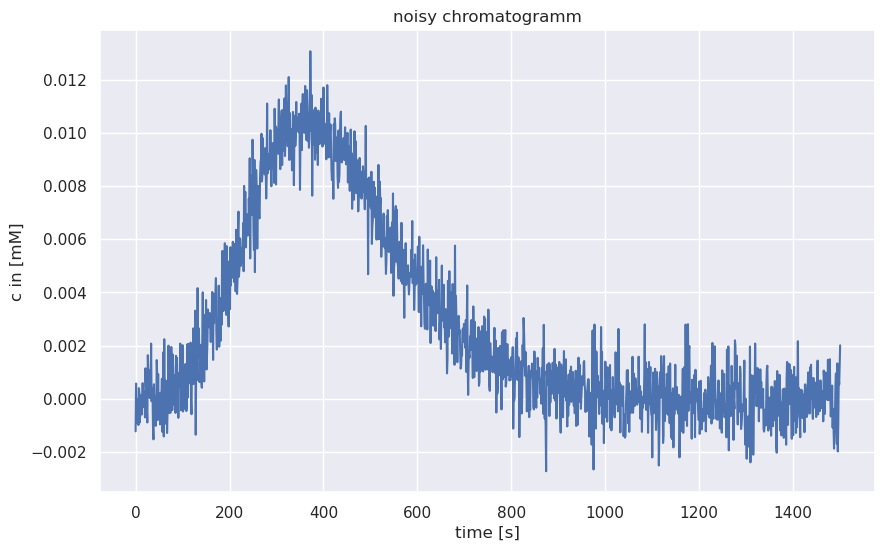

In [28]:
"""
plots one of the noised up chromatogramms
"""

%matplotlib inline

test_chromatogramm = np.genfromtxt("data/samples/std_sample_"+str(3)+".csv", delimiter = ",")

plt.plot(np.arange(duration),test_chromatogramm[0,:])
plt.xlabel("time [s]")
plt.ylabel("c in [mM]")
plt.title("noisy chromatogramm")
plt.show()

In [ ]:
''' 
Set Parameter of the linear error-model for injection-time and injected mass that can be found in the CADET-Paper 
corresponds to the low-noise scenario 
'''

rng = np.random.default_rng()
sigma_t = 1 #[s]
sigma_mass = 0.05 #[mg]
sigma_meas = 5e-5 #careful, this variable is now set to a different state then earlier 


In [ ]:
""" 
create artificial data according to the linear-error model found in the cadet_paper, 
where, in addition to gaussian measurement noise, injection time and injected mass are assumed 
to follow a normal distribution 
"""
eps_t = rng.standard_normal((runs,samples))
eps_mass = rng.standard_normal((runs,samples))

for i in range(runs) : 
    em_artificial_data = np.zeros((samples,duration))
    for j in range(samples):
        process = configure_process(T_nom[i] + sigma_t*eps_t[i,j],m_nom + sigma_mass*eps_mass[i,j])       
        numerical_solution = forward_run(process).flatten()
        numerical_solution = add_noise(numerical_solution,0,sigma_meas)
        em_artificial_data[j,:] = numerical_solution[0:1501] #technically we would have to do: solution-interpolate and then at these timepoints                 
    np.savetxt("data/samples/em_sample_"+str(i)+".csv", em_artificial_data,delimiter = ",", header = '') 
    if i % 2 == 0:
        print("iteration: " + str(i))     

In [ ]:
""" 
here reduced values are defined, to limit the parameter_estimation process to specific injection_times and a certain number of samples 
if you want to do a full estimation on the 18 x 1000 chromatograms, either remove this cell and change the corresponding variable_names 
in the next code_cells back to runs, T_nom, and samples, or plug in the values 18, 1000, and T_nom into this code_cell 
"""

red_runs = 9
red_samples = 250# int(samples/4)
T_nom_red = np.array([T_nom[2*i] for i in range(red_runs)])
print(T_nom_red,red_samples)

[ 60 154 248 342 436 530 624 718 812] 250


In [ ]:
""" 
parameter-estimation on the data with  minor gaussian noise
due to time-constraints, a smaller dataset
"""

std_parameter_estimates = np.zeros((red_runs, red_samples, 2))
std_covariance_matrices = np.zeros((red_runs, 2,2))

for i in range(red_runs):
    noisy_data = np.genfromtxt("data/samples/std_sample_"+str(2*i)+".csv", delimiter = ",")
    process = configure_process(T_nom_red[i],m_nom)
    for j in range(red_samples):
        reference = ReferenceIO("noisy_data", np.arange(duration), noisy_data[j,:].T)
        params = compute_parameters(reference, process)    
        std_parameter_estimates[i,j,:] = params
        if j% 10 == 0:
            print("sample nr : ", j)

    std_covariance_matrices[i,:] = np.cov(std_parameter_estimates[i,:].T)
    print("run: "+str(i))
    
np.save("data/statistics/std_covariance_matrices",std_covariance_matrices)
np.save("data/statistics/std_parameter_estimates", std_parameter_estimates)


In [12]:
"""
parameter-estimation on the data generated via the error-modeling process 
Smaller Data_Set and run due to time_constraints
"""
em_parameter_estimates = np.zeros((red_runs, red_samples, 2))
em_covariance_matrices = np.zeros((red_runs, 2,2))

for i in range(red_runs):
    noisy_data = np.genfromtxt("data/samples/em_sample_"+str(2*i)+".csv", delimiter = ",")
    process = configure_process(T_nom_red[i],m_nom)
    for j in range(red_samples):
        reference = ReferenceIO("noisy_data", np.arange(duration), noisy_data[j,:].T)
        params = compute_parameters(reference, process)    
        clear_output(wait=True) 
        em_parameter_estimates[i,j,:] = params
    #estimate covariance-matrices 
    print("run: "+str(i))
    em_covariance_matrices[i,:] = np.cov(em_parameter_estimates[i,:].T)
    
np.save("data/statistics/em_covariance_matrices",em_covariance_matrices)
np.save("data/statistics/em_parameter_estimates", em_parameter_estimates)


run: 8


In [ ]:
"""
Compute Determinants and estimate CI via resampling 
"""


std_dets = np.array([np.linalg.det(std_covariance_matrices[i,:]) for i in range(red_runs)])/np.sqrt(5.7*4.88)
em_dets = np.array([np.linalg.det(em_covariance_matrices[i,:]) for i in range(red_runs)])/np.sqrt(5.7*4.88)

std_confidence_intervals = resampling(np.load("data/statistics/std_parameter_estimates.npy"))
em_confidence_intervals = resampling(np.load("data/statistics/em_parameter_estimates.npy"))

np.save("data/statistics/std_dets",std_dets)
np.save("data/statistics/em_dets",em_dets)

np.save("data/statistics/std_ci",std_confidence_intervals)
np.save("data/statistics/em_ci", em_confidence_intervals)


In [11]:
std_estimates = np.load("data/statistics/std_parameter_estimates.npy")
em_estimates = np.load("data/statistics/em_parameter_estimates.npy")

print(std_estimates.shape)

(9, 250, 2)


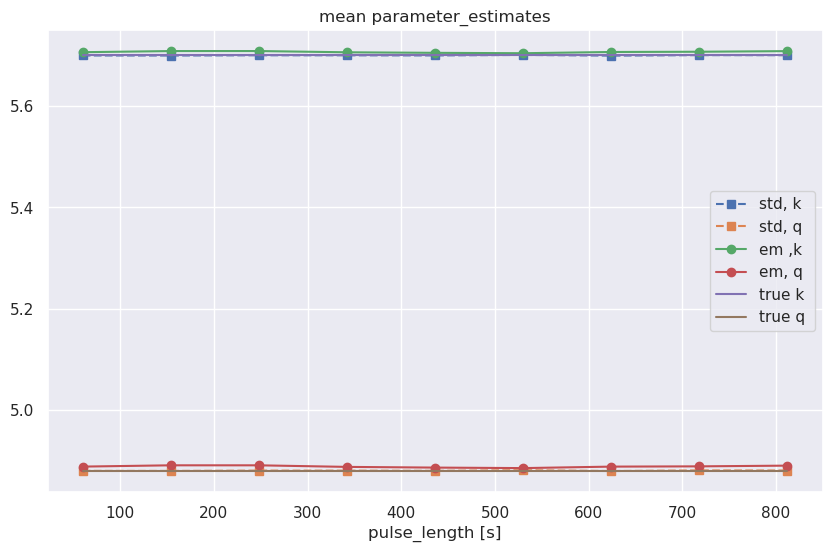

In [ ]:
""" 

"""


std_means = np.zeros((red_runs,2))
em_means = np.zeros((red_runs,2))
for i in range(red_runs):
    std_means[i,:] = np.mean(std_estimates[i,:],axis=0)
    em_means[i,:] = np.mean(em_estimates[i,:],axis = 0)
    
plt.figure()
plt.title("mean parameter_estimates")
plt.xlabel("pulse_length [s]")
plt.plot(T_nom_red, std_means[:,0], label ="std, k", ls = "--", marker ="s")
plt.plot(T_nom_red, std_means[:,1], label ="std, q", ls = "--", marker = "s")
plt.plot(T_nom_red, em_means[:,0] ,label ="em ,k", ls = "-", marker = "o")
plt.plot(T_nom_red, em_means[:,1] ,label ="em, q", ls = "-", marker="o")
plt.plot(T_nom_red, 5.7*np.ones(9), label ="true k ", ls = "-")
plt.plot(T_nom_red, 4.88*np.ones(9), label = "true q", ls = "-")

plt.legend()
plt.show()

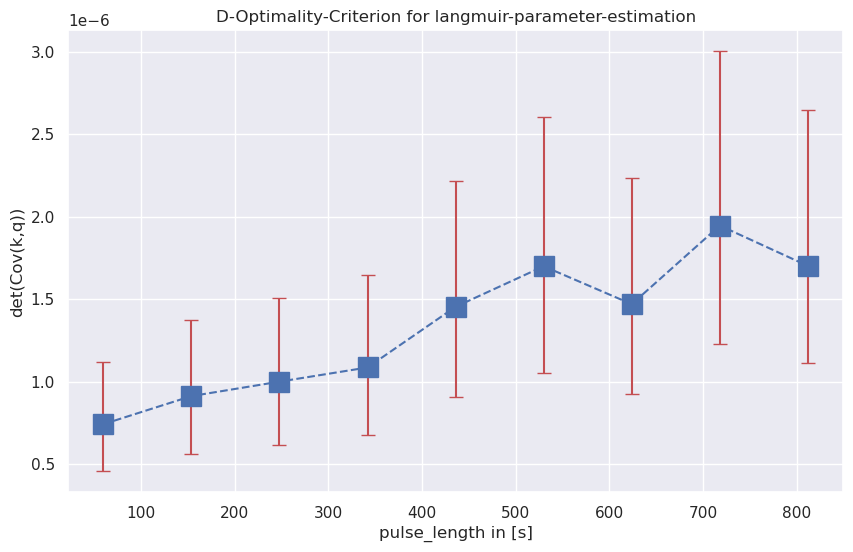

In [27]:
"""Plotting!"""
%matplotlib inline

std_dets = np.load("data/statistics/std_dets.npy")
std_confidence_intervals = np.load("data/statistics/std_ci.npy")

plt.figure()
plt.title("D-Optimality-Criterion for langmuir-parameter-estimation")
plt.xlabel("pulse_length in [s]")
plt.ylabel("det(Cov(k,q))")
#plt.plot(T_nom,std_dets,label = "k_max & q", linestyle = "--", marker = "s", ms = 15)

plt.errorbar(T_nom_red,np.sqrt(std_dets), yerr=np.sqrt(std_confidence_intervals.T/(5.7*4.88)), linestyle = "--", marker="s", ms=15,capsize=5,ecolor="r")
plt.show()


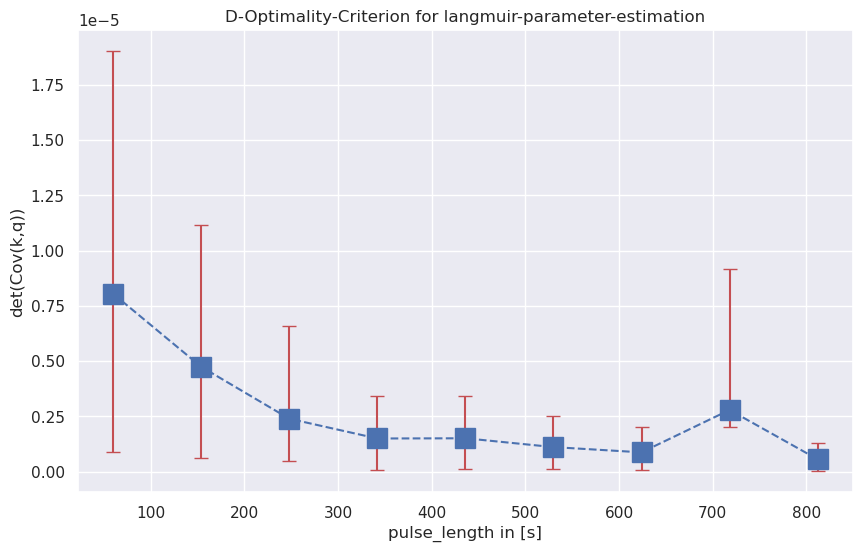

In [90]:
"""Plotting!"""
%matplotlib inline

em_dets = np.load("data/statistics/em_dets.npy")
em_confidence_intervals = np.load("data/statistics/em_ci.npy")

plt.figure()
plt.title("D-Optimality-Criterion for langmuir-parameter-estimation")
plt.xlabel("pulse_length in [s]")
plt.ylabel("det(Cov(k,q))")
#plt.plot(T_nom,std_dets,label = "k_max & q", linestyle = "--", marker = "s", ms = 15)

plt.errorbar(T_nom_red,np.sqrt(em_dets/5.7*4.88), yerr=np.sqrt(em_confidence_intervals.T/np.sqrt(5.7*4.88)), linestyle = "--", marker="s", ms=15,capsize=5,ecolor="r")
plt.show()


In [ ]:
"""
tries to compute a surrogate model using the polynomial chaos expansion method
sadly this does not work well. 
"""



model = lambda  T,m : forward_run(configure_process(T,m))
order = 25
T_rand = chaospy.Normal(T_nom_red[0],sigma_t) 
m_rand = chaospy.Normal(m_nom,sigma_mass)
joint = chaospy.J(T_rand,m_rand)
gauss_quads = chaospy.generate_quadrature(order, joint, rule="gaussian") 
nodes,weights = gauss_quads        
model_evals= np.array([model(node[0],node[1]) for node in nodes.T])
expansion = chaospy.generate_expansion(order,joint) 
cadet_surrogate = chaospy.fit_quadrature(expansion,nodes,weights,model_evals) 